In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from data_generators import *

## 1 Higgs boson discovery
In a particle physics experiment, we measure 3 quantities for events whose final state particles are two photons ($\gamma \gamma$). According to the Standard Model (SM) These events will include some signal events from a Higgs decay $H \rightarrow \gamma \gamma$, but also many background events from other processes whose final state is $\gamma \gamma$.

The three observables we measure are:
* $E_T$: the transverse energy of the leading jet.
* $m_{\gamma \gamma}$: the invariant mass of the two final state photons.
* $\Delta \phi _{jj}$: the angular separation between the two leading jets. 


We simulate data according to two hypotheses:
1. $H_0$: the background-only hypothesis, i.e. the SM without a Higgs boson present.
2. $H_1$: the signal hypothesis, i.e. the full SM.

In [2]:
sm_background = StandardModelBackgroundGenerator()
sm_signal = StandardModelSignalGenerator()

n_data_sim = int(1e5)

h_0_simulated_data = generate_data(n=n_data_sim, background_generator=sm_background, signal_generator=sm_signal,
                                  signal_prob=0)
h_1_simulated_data = generate_data(n=n_data_sim, background_generator=sm_background, signal_generator=sm_signal)

In [3]:
n_data_ex = int(1e4)
experimental_data = generate_data(n=n_data_ex, background_generator=sm_background, signal_generator=sm_signal)
experimental_data.head()

,E_t,delta_phi,m_jj,signal
0,41.134895,-1.292983,52.733414,0.0
1,59.606384,-0.725790,75.636650,0.0
2,127.110115,1.595841,62.711376,0.0
3,137.047592,-1.600107,58.548950,0.0
4,198.944046,0.831374,59.318333,0.0


This is roughly what experimental data would like, after a few pre-processing steps (detector simulation and particle reconstruction), of course except for the column indicating whether an event was a signal event, which we would not know from experiment (we know it in this case because our experimental data is actually simulated). 

We know from theory that the number of Higgs boson events is expected to experience a bump in events at $m_{\gamma\gamma} \approx m_H \approx 125$ GeV. To analyse the data, we group the data into bins in $m_{\gamma \gamma}$ of size 1 GeV, and plot the predictions of $H_0$ and $H_1$ alongside the experimental values.

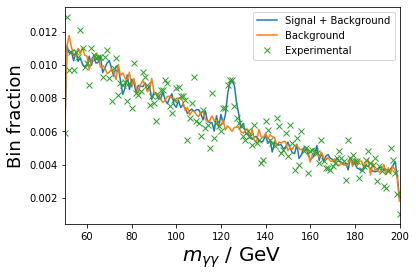

In [4]:
def get_bin_fractions(series):
    series_hist = series.round().value_counts().sort_index()
    return series_hist/series_hist.sum()

h_0_sim_hist = get_bin_fractions(h_0_simulated_data['m_jj'])
h_1_sim_hist = get_bin_fractions(h_1_simulated_data['m_jj'])
ex_hist = get_bin_fractions(experimental_data['m_jj']) 
h_1_sim_hist.plot(label='Signal + Background', xlim=[60, 190])
h_0_sim_hist.plot(label='Background')
plt.plot(ex_hist.index, ex_hist.values, 'x', label='Experimental')
plt.xlabel('$m_{\gamma \gamma}$ / GeV', fontsize=20)
plt.ylabel('Bin fraction', fontsize=18)
plt.legend()

This certainly looks like we have a Higgs boson, but with what statistical significance could we make that statement? In a real experiment we would perform a rigorous statistical test, but for our purposes it is sufficient to use the approximation

$$ z \approx \frac{S}{\sqrt{B}} \, ,$$

where $S$ is the number of signal events and $B$ is the number of background events (in reality we would not have access to these numbers for experimental data, but we have actually simulated our 'experimental' data).

The significance $z$ is related to the $p$-value by

$$ p = \Phi (z) \, ,$$

where $\Phi$ is the cumulative distribution function of the standard Gaussian.

In [5]:
def estimate_significance(data):
    return (data['signal'].sum())/np.sqrt(data['signal'].count())


print('z = {:.2f}'.format(estimate_significance(experimental_data)))

z = 1.25


So we have a result that is slightly below the significance required to claim discovery in particle physics ($z=5$). In order to better isolate our signal, we need to perform cuts on the data, which means placing restrictions on the observables. To inform us about which cuts to make, we can plot the distribution of $E_T$ for the signal events in our simulated data.

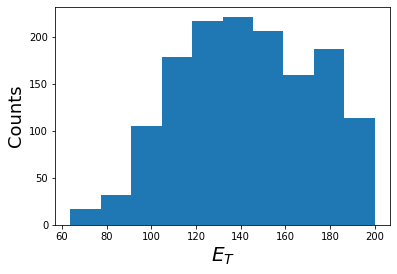

In [6]:
h_1_signal_data = h_1_simulated_data[h_1_simulated_data['signal'] == 1]

h_1_signal_data['E_t'].plot.hist()
plt.xlabel('$E_T$', fontsize=20)
plt.ylabel('Counts', fontsize=18)
plt.show()

So it appears that signal events (according to our simulation) tend to have higher values of $E_T$, so it makes sense to use a cut enforcing this such as

$$ E_T > 100 \text{ GeV} \, .$$

In [7]:
cut_data = experimental_data[experimental_data['E_t'] > 100]
estimate_significance(cut_data)

1.6666601281420061

Thus we now have the significance level required to claim the discovery of a Higgs boson.


## 2 Measurement of Higgs boson properties
A [2018 experimental paper](https://arxiv.org/abs/1802.04146) from the ATLAS collaboration attempted to measure the Higgs boson properties through the above-mentioned decay channel. The authors noted that the absolute vaue of $\Delta \phi _{jj}$ was sensitive to some proposed new physics (namely CP violating Higgs interactions). 

By this they meant that the SM and this new, beyond the Standard Model (BSM) physics predict different distributions of $|\Delta \phi _{jj}|$ in the data:

In [34]:
n_data = int(1e5)
signal_prob = 1  # artificially increase signal probability so we don't have to make cuts again
bsm_generator = BSMSignalGenerator()

sm_data = generate_data(n_data, sm_background, sm_signal, signal_prob=signal_prob)
bsm_data = generate_data(n_data, sm_background, bsm_generator, signal_prob=signal_prob)

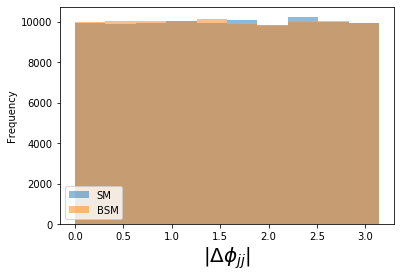

In [36]:
delta_phi_data = pd.concat([sm_data['delta_phi'], bsm_data['delta_phi']], axis=1)
delta_phi_data.columns = ['SM', 'BSM']
delta_phi_data.abs().plot.hist(alpha=0.5)
plt.xlabel('$|\Delta \phi _{jj}|$', fontsize=20)
plt.legend(loc='lower left')
plt.show()

They constructed an observable based on this expected difference in the distributions, When they evaluated it on the collected data, they found no contributions of any significance ($z \approx 0$).

However, a [phenomonology paper in 2019](https://arxiv.org/abs/1808.06577) realised that taking the distribution signed version of $\Delta \phi _{jj}$, i.e. without taking the absolute value, proved much more sensitive to the new physics:

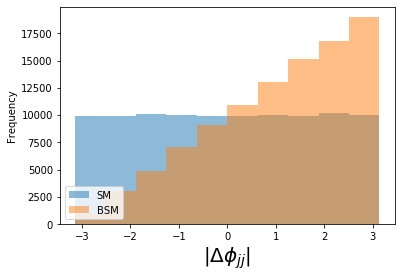

In [38]:
delta_phi_data.plot.hist(alpha=0.5)
plt.xlabel('$\Delta \phi _{jj}$', fontsize=20)
plt.legend(loc='lower left')
plt.show()

This unsigned distribution is much more sensitive to our new physics, as we can construct an observable $A$ that measures the asymmetry of the data in $\Delta \phi _{jj}$:

$$ A = \frac{\text{count}(\Delta \phi _{jj} > 0) - \text{count}(\Delta \phi _{jj} < 0) }{\text{total count}} \, .$$


The authors evaluated this observable on the data collected in 2018, and small asymmetry $A=0.3\pm 0.2$ (while the null hypothesis would predict a value of 0). This corresponds to a significance of about $z=1.5$, suggesting further work should be done to investigate this possible new physics. It also allowed them to place more restrictive confidence intervals on the parameters of the new physics than the analysis performed in 2018.

